# Introduction

This project aims to develop a neural network model to distinguish between dogs and cats from a set of images. To that end, convolutional and pooling layers are used for feature extraction. The training set involves a series of images whose title reveals whether dog or a cat is shown. The test images however, does not contain any information about their content. The binnary accuracy of the model is evaluated in terms of convergence for validation and training data, both obtained from the original training set. Finally, the model is applied to the test images to make predictions.

<img src='./dogAndCat.jpg'  align = 'center'>

## Table of Contents

1. Load Train and Test Data
2. Data Exploration
3. Data Preparation
    * 3.1. Training and Validation Data
    * 3.2. Data Augmentation
4. CNN Model
5. Model Evaluation
6. Test Data: Make Predictions

# 1. Load Train and Test Data

We first load the necessary packages which will be used:

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import zipfile
import glob
import os
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

Both train and test data are provided in .zip files, so we first check we have these:

In [2]:
zip_file = glob.glob('./*.zip') 
zip_file

['./test.zip', './train.zip']

The next step is to extract the contents from both .zip files into a temporal folder:

In [3]:
 # Function to create a temporal folder where contents are extracted
def extract_zip(file):
    with zipfile.ZipFile(file,'r') as zip_ref:
        zip_ref.extractall('tempFolder')
        
# We extract the contents from .zip files
for files in zip_file:
    extract_zip(files)

We now specify the paths required to access both the train and test data.

In [4]:
# Path to access the train data
path_train = './tempFolder/train'

# Path to access the test data
path_test = './tempFolder/test1'

Finally, we collect the files names in two lists for train and test data:

In [5]:
def get_files(path):
    file_list = []
    for file in os.listdir(path):
        file_list.append(file)
    return file_list

In [6]:
X_train = get_files(path_train)
X_test = get_files(path_test)

# 2. Data Exploration

Let's check some of the contents available in the train and test folder:

In [7]:
print(f'There are {len(os.listdir(path_train))} train files')

There are 25000 train files


In [8]:
print(f'There are {len(os.listdir(path_test))} test files')

There are 12500 test files


In [9]:
os.listdir(path_train)[:15]

['dog.8011.jpg',
 'cat.5077.jpg',
 'dog.7322.jpg',
 'cat.2718.jpg',
 'cat.10151.jpg',
 'cat.3406.jpg',
 'dog.1753.jpg',
 'cat.4369.jpg',
 'cat.7660.jpg',
 'dog.5535.jpg',
 'cat.8553.jpg',
 'cat.9895.jpg',
 'cat.1211.jpg',
 'dog.3144.jpg',
 'dog.775.jpg']

In [10]:
os.listdir(path_train)[-15:]

['cat.6567.jpg',
 'dog.4632.jpg',
 'cat.9654.jpg',
 'dog.10205.jpg',
 'cat.7679.jpg',
 'dog.2243.jpg',
 'cat.11256.jpg',
 'dog.9316.jpg',
 'cat.4370.jpg',
 'dog.6025.jpg',
 'dog.8008.jpg',
 'dog.1992.jpg',
 'dog.12412.jpg',
 'cat.2701.jpg',
 'cat.10148.jpg']

As observed, the provided files are .jpg images of dogs and cats. Taking into account the title of each image includes the animal appearing in the image itself, we create dog and cat categories and collect them in the list y_train:

In [11]:
def make_categories(path):
    label_list = []
    for file in os.listdir(path):
        category = file.split('.')[0]
        label_list.append(category)
    return label_list

In [12]:
y_train = make_categories(path_train)

In [13]:
animal_cat = set(y_train)
print(f'Animal categories are: {animal_cat}')

Animal categories are: {'dog', 'cat'}


We now create a dataframe gathering all the images and their corresponding caregory:

In [14]:
df_train = pd.DataFrame({'image': X_train, 'animal': y_train})

In [15]:
df_train.head()

,image,animal
0,dog.8011.jpg,dog
1,cat.5077.jpg,cat
2,dog.7322.jpg,dog
3,cat.2718.jpg,cat
4,cat.10151.jpg,cat


Let's see how the animals are represented in the data. First, let's look at how many dogs and cats we have:

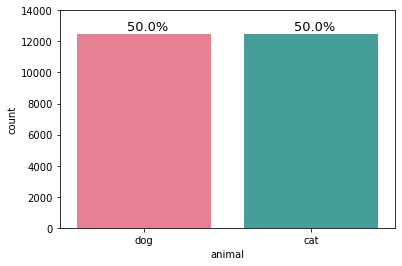

In [16]:
pt= sns.countplot(data = df_train, x='animal', palette='husl');
plt.ylim(0, 14e3) # Adjust ylim for visualization purposes
for p in pt.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_train['animal']))
    x = p.get_x() + p.get_width() / 2  - 0.1
    y = p.get_y() + p.get_height() 
    pt.annotate(percentage, (x, y), size = 13, va='bottom')
plt.show()

As obseved, both categories have the same representation, each one with 50 %. Therefore, we do not need to worry about one category being dominant and the other being underrepresented.

Let's visualize two of the available images, one from each animal category. To that end, we can randomly or manually pick one image of a cat and one image of a dog.

dog.12324.jpg
cat.2411.jpg


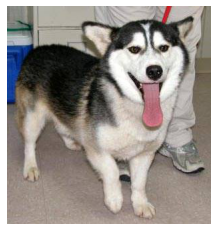

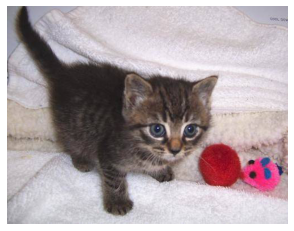

In [17]:
random_choice = False # True for random choice

for animal in animal_cat:

    condition = df_train['image'].str.contains(animal)

    if random_choice: # Random selection of image
        pic = df_train['image'][condition].sample(1).iloc[0]
    else: # Manual selection of image
        if animal == 'dog': pic = 'dog.12324.jpg'
        else: pic = 'cat.2411.jpg'
    print(pic)
    img = load_img(path_train+'/'+pic) 
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

See how cute they are! :)

# 3. Data Preparation

## 3.1. Training and Validation Data

Let's first split the training data into training and validation data. In this way, the training data will be used to fit the model whereas the validation data will be used to evaluate the model performance. This helps us to better know if our model is good at generalization or on the contrary, it is prone to overfitting. In this case, the validation data will account for 20 % of the initial training data.

In [18]:
train_df, valid_df = train_test_split(df_train,test_size=0.2, random_state=42)

In [19]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

Let's see now how the animals are evenly distributed in these datasets:

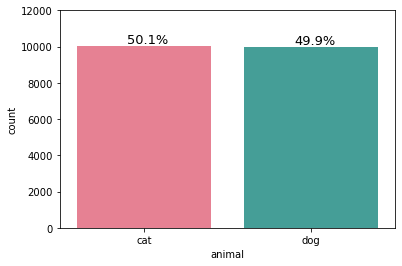

In [20]:
pt= sns.countplot(data = train_df, x='animal', palette='husl');
plt.ylim(0, 12e3) # Adjust ylim for visualization purposes
for p in pt.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(train_df['animal']))
    x = p.get_x() + p.get_width() / 2  - 0.1
    y = p.get_y() + p.get_height() 
    pt.annotate(percentage, (x, y), size = 13, va='bottom')
plt.show()

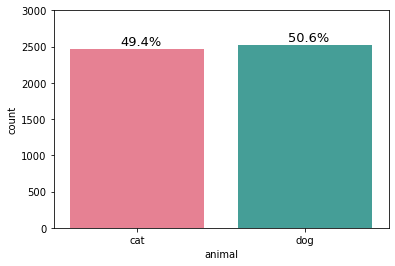

In [21]:
pt= sns.countplot(data = valid_df, x='animal', palette='husl');
plt.ylim(0, 3e3) # Adjust ylim for visualization purposes
for p in pt.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(valid_df['animal']))
    x = p.get_x() + p.get_width() / 2  - 0.1
    y = p.get_y() + p.get_height() 
    pt.annotate(percentage, (x, y), size = 13, va='bottom')
plt.show()

As observed, we have good distribution of both categories in both datasets.

## 3.2. Data Augmentation

In this step, we are going to generate additional training data based on the already existing images. To that end, a series of transformations are defined using ImageDataGenerator and applied to the existing images (such as image rotation, flip, zoom, etc.) by means of flow_from_dataframe, and consequently new images are created for training. In this way, the moder will be able to better generalize the results.

Let's first define the image parameters. In this case, we will have images containing 128 x 128 pixels with 3 RGB colour channels. In addition, we set the value of the batch size, which represents the number of samples the model need to run through in order to update the internal parameters.

In [26]:
image_width=128
image_height=128
image_size=(image_width, image_height)
image_channels = 3
batch_size=16

### 3.2.1 Training data

We now define the train generator with all the transformations that will be applied to the existing images:

In [27]:
train_imggen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [28]:
train_generator = train_imggen.flow_from_dataframe(
    train_df, 
    path_train, 
    x_col='image',
    y_col='animal',
    target_size= image_size,
    class_mode='binary', # We only have dog/cat categories
    batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


### 3.2.1 Validation data

In the same way, we apply transformations to the validation data. Nonetheless, in this case we only rescale the pixels values as we are not interested in using these data to fit the model. Taking into account that the maximum value of a pixel is 255, we rescale accordingly. 

In [29]:
valid_imggen  = ImageDataGenerator(rescale=1./255.)

In [30]:
validation_generator = valid_imggen.flow_from_dataframe(
    valid_df, 
    path_train, 
    x_col='image',
    y_col='animal',
    target_size=image_size,
    class_mode='binary', # We only have dog/cat categories
    batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


# 4. CNN Model

In this section, we create the CNN model. In this case, we are going to use three convolutional layers with different number of filters and ReLU activation function for feature extration. In order to reduce overfitting, dropout function is included, which is based on randomly dropping out a specified fraction of a layer's input units at every step, therefore making the model more flexible. Additionally, batch normalization is included to minimize unstable training behaviour. In addition, we apply maximum pooling in the previously generated feature map in order to enhance these features by condensing the image based on the most active pixels. Finally, the flatten layer converts the previous outputs to one dimensional inputs required in the classifier head. The classifier is consist of the previously mentioned input layer, three hidden layers of 512, 54 and 32 units and one output layer with one binary unit, as we only have two categories (cats and dogs) to classify. To that end, sigmoid function in used in the last step.

In [31]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(image_width, image_height, image_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 

We now compile the model with Adaptive Moment Estimation (ADAM) optimizer. In this case, we aim to minimize the loss function of binary cross entropy. In addition, specify binary accuracy as a metric to be evaluated by the model when running.

In [32]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

Moreover, we add early stopping callback in order to stop the model from running when the values converge and thus, no there is no need of further iterations.

In [33]:
earlystop = EarlyStopping(patience=10)
callbacks = [earlystop]

Finally, we set the number of epochs and we run the model. Epochs value represents the number of times the model will run through the whole dataset if no early stopping occurs.

In [34]:
epochs=100
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=valid_df.shape[0]//batch_size,
    steps_per_epoch=train_df.shape[0]//batch_size,
    callbacks=callbacks)

# 5. Model Evaluation

Let's look now at the loss and accuracy results and variation for both the training and validation datasets.

In the figure below, we can see how the loss progressively decreases with the number of epochs until it converges to a quasi-static value. As obverved, the training data presents a smooth decrease whereas the validation data is more sensitive and noisy, showing numerous peaks. Despite these peaks, we can clearly see a general decrease of the computed loss as well.

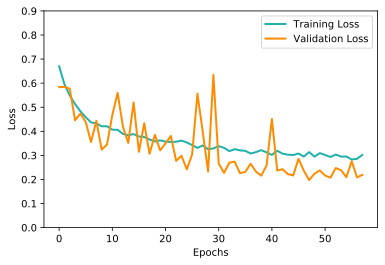

In [22]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('./history.csv', index=False)
#history_df = pd.read_csv('./history.csv')

sns.lineplot(y = 'loss', x = history_df.index, data=history_df, lw = 2, color = 'lightseagreen')
sns.lineplot(y = 'val_loss', x = history_df.index, data=history_df, lw = 2, color = 'darkorange')
plt.ylim(0, 0.9);
plt.ylabel('Loss');
plt.xlabel('Epochs');
plt.legend(labels=["Training Loss","Validation Loss"]);

#from IPython.core.display import SVG
#SVG(filename='output_loss.svg')

In case of the binary accuracy, we can see a progressive increase with the number of epochs. In the same as before, the training accuracy smoothly increases whereas the validation accuracy is more unstable. In general, an improvement of accuracy is observed in both cases reaching a convergence value near 90%.

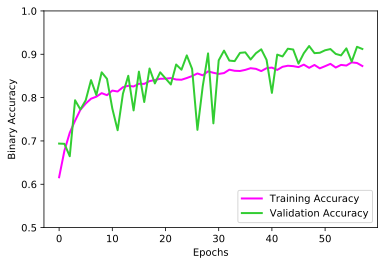

In [23]:
sns.lineplot(y = 'binary_accuracy', x = history_df.index, data=history_df, lw = 2, color = 'magenta')
sns.lineplot(y = 'val_binary_accuracy', x = history_df.index, data=history_df,lw = 2, color = 'limegreen')
plt.ylim(0.5, 1);
plt.ylabel('Binary Accuracy');
plt.xlabel('Epochs');
plt.legend(labels=["Training Accuracy","Validation Accuracy"], loc= 'lower right');

#from IPython.core.display import SVG
#SVG(filename='output_acc.svg')

# 6. Test Data: Make Predictions

Let's now try out our fitted model in new data without any previous information about the animal appearing in the image. We first fetch the test data and create a dataframe with all the provided images.

In [38]:
test_df = pd.DataFrame({'image': X_test})
test_samples = test_df.shape[0]

In [39]:
test_df.head()

,image
0,1.jpg
1,10.jpg
2,100.jpg
3,1000.jpg
4,10000.jpg


As observed, the titles do not reveal the animal included.

In the same way as before, we scale the images as we did with the validation data:

In [40]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    path_test, 
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 12500 validated image filenames.


Now we apply the model to make predictions:

In [41]:
y_test = model.predict_generator(test_generator, steps=np.ceil(test_samples/batch_size))

Taking into account that Sigmoid function is used, it will deliver output values between 0 and 1 as we have two categories. The output values will represent the probability that one image belongs to category 1. Therefore, a threshold of 0.5 is considered to classify the image as 1 or 0, that means that images with probabilies above 50 % (value of 0.5) will be considered to belong to category 1. In the same way, probabilities images with probabilities below the threshold will be classified as category 0.

In [42]:
predictions = [int(round(val[0])) for val in y_test]

The predictions are now added to the test dataframe alongside the titles:

In [43]:
test_df['Predictions'] = predictions

We check that the output values are binary:

In [45]:
test_df.head()

,image,Predictions
0,5915.jpg,1
1,8371.jpg,0
2,12304.jpg,1
3,9464.jpg,0
4,2426.jpg,0


As mentioned above, a binary classification is made with values of 0 and 1 corresponding to both animal categories. However, it is needed to check which animal corresponds to what numerical label:

In [46]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
label_map

{0: 'cat', 1: 'dog'}

We can see that cats are represented by 0 and dogs are represented by 1. We now can replace the predictions with numerical labels to their corresponding animal categories.

In [47]:
test_df['Predictions'] = test_df['Predictions'].replace(label_map)

In [48]:
test_df.head(9)

,image,Predictions
0,5915.jpg,dog
1,8371.jpg,cat
2,12304.jpg,dog
3,9464.jpg,cat
4,2426.jpg,cat
5,4988.jpg,dog
6,2490.jpg,dog
7,7361.jpg,dog
8,6061.jpg,dog


Let's now look at the results and check the predictions made for the first nine images.

In [ ]:
plt.figure(figsize=(8, 10))
for i in range(0,9):
    img = load_img(path_test+'/'+test_df['image'].iloc[i])
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.xlabel(test_df['Predictions'].iloc[i])

    # Selecting the axis-X making the bottom and top axes False.
    plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

    # Selecting the axis-Y making the right and left axes False
    plt.tick_params(axis='y', which='both', right=False,
                left=False, labelleft=False)

    # Iterating over all the axes in the figure
    # and make the Spines Visibility as False
    for pos in ['right', 'top', 'bottom', 'left']:
        plt.gca().spines[pos].set_visible(False)

plt.tight_layout()

<img src='./results.png'  align = 'center'>

We can see the model correctly predicted the images we checked! :)

Let's finally look at the number of predicted dogs and cats. As seen in the figure below, both cats and dogs are present in nearly half of the images: 

In [ ]:
pt= sns.countplot(data = test_df, x='Predictions', palette='husl');
plt.ylim(0, 10e3) # Adjust ylim for visualization purposes
for p in pt.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(test_df['Predictions']))
    x = p.get_x() + p.get_width() / 2  - 0.1
    y = p.get_y() + p.get_height() 
    pt.annotate(percentage, (x, y), size = 13, va='bottom')
plt.show()

<img src='./results_2.png'  align = 'center'>